# Задание Lite

1. Сделайте выделение следующих классов по отдельности:

  - Пола
  - Того, что за окном
  - Людей
  - Батарей
  - Лампочек
 

2. Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке.

3. Проверьте различные batch_size.

4. Проверьте различные активационные функции.

5. Напишите свои выводы.

# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import concatenate, Activation, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Сегментация стройки

**Сделайте выделение следующих классов по отдельности:**

  - Пола
  - Того, что за окном
  - Людей
  - Батарей
  - Лампочек

### Задание глобальных параметров

In [ ]:
img_width  = 176     # Ширина
img_height = 240     # Высота
directory       = '/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/'  
train_directory = 'Тренировочная_стройка/'
val_directory   = 'Проверочная_стройка/'
num_classes = 6     # Количество классов

## Загрузка изображений



### Оригинальные изображения

In [ ]:
train_images = []  # Список обучающей выборки
val_images = []    # Список проверочной выборки

curr_time = time.time()
for filename in sorted(os.listdir(directory + train_directory + 'Исходники')):
  train_images.append(image.load_img(os.path.join(directory + train_directory + 'Исходники', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(train_images))

curr_time = time.time()
for filename in sorted(os.listdir(directory + val_directory + 'Исходники')):
  val_images.append(image.load_img(os.path.join(directory + val_directory + 'Исходники', filename), target_size=(img_width, img_height)))
print (f'Проверочная выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(val_images))

Обучающая выборка завершина. Время загрузки: 36.31 cекунд
Количество изображений:  900
Проверочная выборка завершина. Время загрузки: 25.71 cекунд
Количество изображений:  50


### Проверка полученных изображений

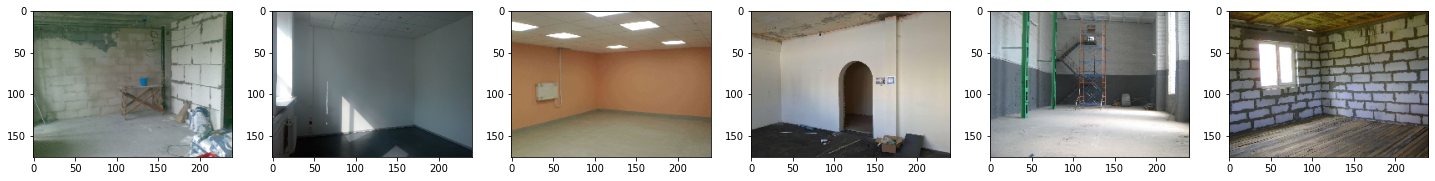

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img)
plt.show()

### Сегментированные изображения

In [ ]:
train_segments = []
val_segments = []

curr_time = time.time()
for filename in sorted(os.listdir(directory + train_directory + 'Размеченные')):
  train_segments.append(image.load_img(os.path.join(directory + train_directory + 'Размеченные', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(train_segments))

curr_time = time.time()
for filename in sorted(os.listdir(directory + val_directory + 'Размеченные')):
  val_segments.append(image.load_img(os.path.join(directory + val_directory + 'Размеченные', filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(val_segments))

Обучающая выборка завершина. Время загрузки: 50.56 cекунд
Количество изображений:  900
Обучающая выборка завершина. Время загрузки: 15.52 cекунд
Количество изображений:  50


### Проверка полученных **сегментированных** изображений

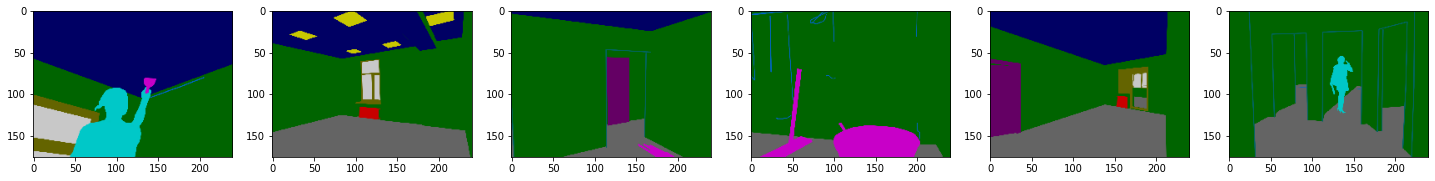

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_segments)
  axs[i].imshow(img)
plt.show()

## Создание выборки



Пол                 - **0**

Того, что за окном  - **1**

Люди                - **2**

Батареи             - **3** 

Лампочки            - **4** 

Все остальное       - **5** 

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
    index=-1
    if   (149>=color[0]>51)   and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=0 # пол


    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (249>=color[2]>=151) : index=1 # внешний мир


    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (249>=color[2]>=151) : index=2 # люди


    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=3 # батарея


    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # источники света

    # Все остальное
    
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=5 # стена
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=5 # проем
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=5 # дверь
    elif (149>=color[0]>=51)  and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=5 # окно
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=5 # колонна
    elif (49>=color[0]>=0)    and (49>=color[1]>=51)   and (249>=color[2]>=151) : index=5 # лестница
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=5 # перила
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=5 # инвентарь
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (249>=color[2]>=151) : index=5 # провода
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=5 # балка

    else: index=5

    return index  

### Дополнительные функции

In [ ]:
# Из индекса в цвет
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index   == 0: color = [100, 100, 100]   # Пол                  -  СЕРЫЙ 
  elif index == 1: color = [0, 0, 100]       # Внешний мир          -  СИНИЙ
  elif index == 2: color = [0, 100, 0]       # Люди                 -  ЗЕЛЕНЫЙ
  elif index == 3: color = [100, 0, 0]       # Батарея              -  КРАСНЫЙ
  elif index == 4: color = [0, 100, 100]     # Источники света      -  ГОЛУБОЙ
  elif index == 5: color = [100, 0, 100]     # Все остальное        -  РОЗОВЫЙ
  return color

In [ ]:
# Функция перевода индекса пикслея в OHE
def rgbToOhe(y, num_classes):
  y_shape = y.shape                          # Запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3)  # (56320, 3)
  yt = []
  for i in range(len(y)):
    yt.append(to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим в OHE
  yt = np.array(yt)
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
  return yt

In [ ]:
# Функция формирования yTrain
def y_pred(data, num_classes):
  yTrain = []
  for seg in data:
    y = image.img_to_array(seg)   # Переводим изображение в numpy-массив
    y = rgbToOhe(y, num_classes)  # Получаем OHE
    yTrain.append(y)
    if len(yTrain) % 100 == 0:
      print(len(yTrain))
  return np.array(yTrain)

## Создание xTrain и yTrain

## xTrain, xVal

In [ ]:
xTrain = []
for img in train_images:
  x = image.img_to_array(img)
  xTrain.append(x)
xTrain = np.array(xTrain)

xVal = []
for img in val_images:
  x = image.img_to_array(img)
  xVal.append(x)
xVal = np.array(xVal)

print('xTrain: ', xTrain.shape)
print('xVal:   ', xVal.shape)

xTrain:  (900, 176, 240, 3)
xVal:    (50, 176, 240, 3)


## yTrain, yVal

In [ ]:
curr_time = time.time()
yTrain = y_pred(train_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

100
200
300
400
500
600
700
800
900
Время обработки: 41.66 минут


In [ ]:
curr_time = time.time()
yVal = y_pred(val_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

Время обработки: 1.82 минут


In [ ]:
# print('xTrain: ', xTrain.shape)
# print('yTrain: ', yTrain.shape)

# print('xVal:   ', xVal.shape)
print('yVal:   ', yVal.shape)

yVal:    (50, 176, 240, 6)


## Сохранение и загрузка массивов  

In [ ]:
# Так как время создания выборки большое сохраним массивы на гугл диск
# # Сохранение
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-xTrain.npy', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-yTrain.npy', yTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-xVal.npy', xVal)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-yVal.npy', yVal)

# Загрузка
xTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-xTrain.npy')
yTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-yTrain.npy')
xVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-xVal.npy')
yVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/База Стройки/Lite-yVal.npy')

# 2. Сделайте свою **собственную** архитектуру и запустите, оцените точность на проверочной выборке.

## **Вариант 1**

Данная нейронная сеть будет лишь с **одним** пробросом между первыми и последними слоями. 

In [ ]:
def unet(num_classes=6, input_shape=(176,240,3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(32, (3,3), padding='same')(img_input)   # (176,240,3)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)           # (176,240,32) 
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  x = MaxPooling2D()(block_1_out)                    # (88,120,32)

  # Block 2

  x = Conv2D(64, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(8, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)                              # (44,60,32)


  # Block 3

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #x = MaxPooling2D()(x)                              # (22,30,128)

  # UP 2

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)  # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)                           # (88,120,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)                           # (88,120,128)                         
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3

  # x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = Conv2D(64, (3,3), padding='same')(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = Conv2D(64, (3,3), padding='same')(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)


  # UP 4

  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)    # (176,240,32)  
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])     # Объединение слоев (176,240,32) и (176,240,32) 

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Выходной

  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)  # (176,240,6)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Собственная функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count=6, n_classes=6):
  indexes = np.random.randint(0, len(xVal), count)
  
  fig, axs = plt.subplots(3, count, figsize=(25,7))
  for i, idx in enumerate(indexes):
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3)))
    pr = predict[0]
    pr1 = []                                # Сегментированная картинка из predicta
    yr2 = []                                # Сегменитрованная картинка из yVal
    pr = pr.reshape(-1, n_classes)          # Решейп предикта
    yr = yVal[idx].reshape(-1, n_classes)   # Решейп yVal
    for k in range(len(pr)):
      pr1.append(index2color(pr[k]))
      yr2.append(index2color(yr[k]))
    
    pr1 = np.array(pr1)
    pr1 = pr1.reshape(img_width, img_height, 3)
    yr2 = np.array(yr2)
    yr2 = yr2.reshape(img_width, img_height, 3)

    img = Image.fromarray(pr1.astype('uint8'))

    axs[0,i].imshow(img.convert('RGBA'))
    axs[1,i].imshow(Image.fromarray(yr2.astype('uint8')))
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8')))
  plt.show()

In [ ]:
model = unet()

### Просмотр модели

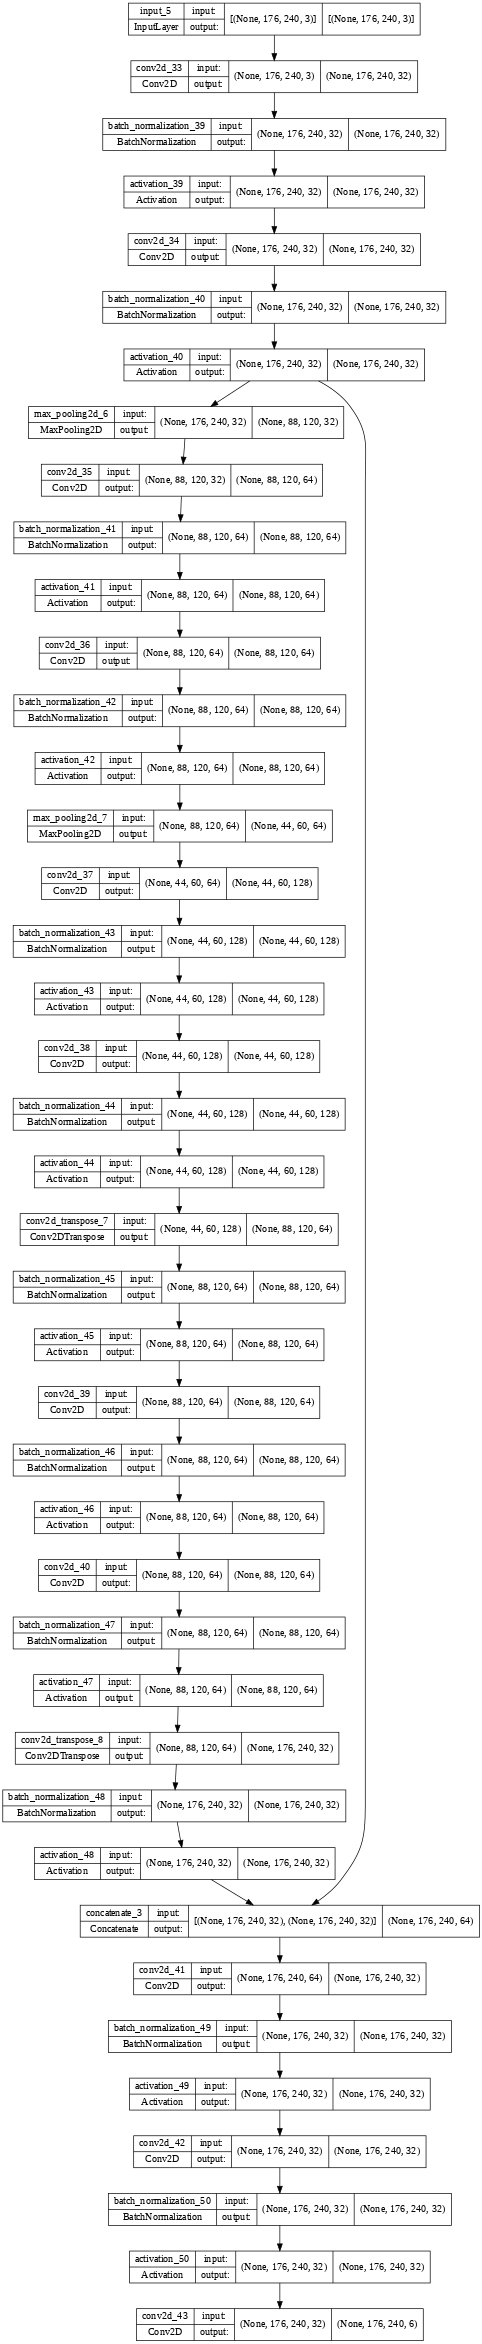

In [ ]:
plot_model(model, show_shapes=True, dpi=50)

### Обучение

In [ ]:
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data=(xVal, yVal))

Epoch 1/50
29/29 [==============================] - 20s 676ms/step - loss: 0.7168 - dice_coef: 0.5687 - val_loss: 1.2916 - val_dice_coef: 0.3133
Epoch 2/50
29/29 [==============================] - 20s 674ms/step - loss: 0.6636 - dice_coef: 0.6075 - val_loss: 1.1634 - val_dice_coef: 0.3747
Epoch 3/50
29/29 [==============================] - 20s 678ms/step - loss: 0.6248 - dice_coef: 0.6364 - val_loss: 1.0843 - val_dice_coef: 0.4462
Epoch 4/50
29/29 [==============================] - 20s 673ms/step - loss: 0.5982 - dice_coef: 0.6534 - val_loss: 1.0231 - val_dice_coef: 0.4589
Epoch 5/50
29/29 [==============================] - 20s 676ms/step - loss: 0.5705 - dice_coef: 0.6724 - val_loss: 0.9572 - val_dice_coef: 0.4980
Epoch 6/50
29/29 [==============================] - 20s 673ms/step - loss: 0.5489 - dice_coef: 0.6891 - val_loss: 0.9312 - val_dice_coef: 0.5191
Epoch 7/50
29/29 [==============================] - 20s 674ms/step - loss: 0.5366 - dice_coef: 0.6987 - val_loss: 0.8708 - val_dic

### Визуализация 

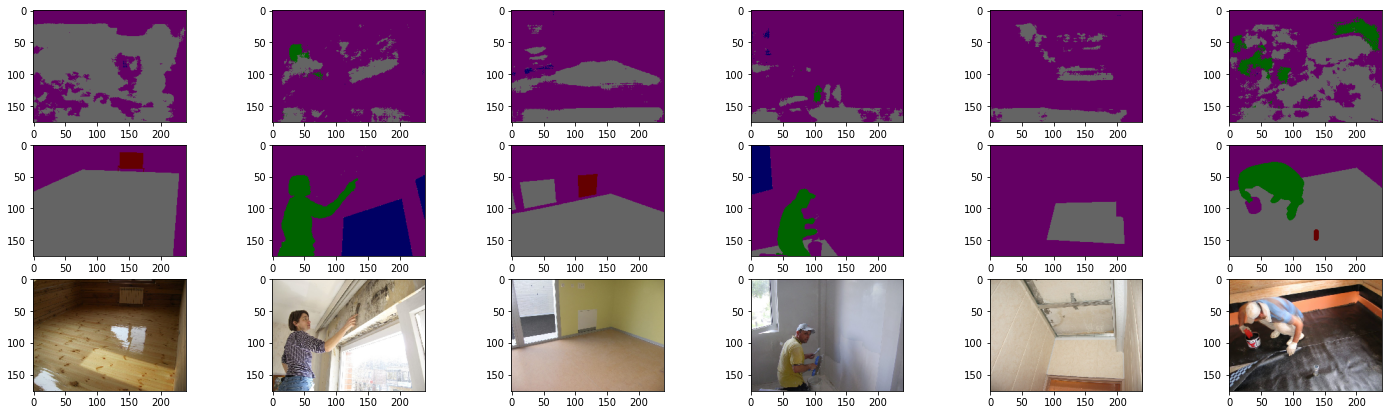

In [ ]:
processImage(model)

## **Вариант 2** - Dense

В данном варианте после последнего **MaxPooling2D** будет слой **Dense**, перед этим вытянутый в вектор и далее снова преобразование в трехмерное пространство.

In [ ]:
def unet_Dense(num_classes=6, input_shape=(176,240,3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(32, (3,3), padding='same')(img_input)   # (176,240,3)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)           # (176,240,32) 
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  x = MaxPooling2D()(block_1_out)                    # (88,120,32)

  # Block 2

  x = Conv2D(64, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)                              # (44,60,32)


  # Block 3

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)                              # (22,30,64)

  # Block 4

  x = Conv2D(32, (3,3), padding='same')(x)          # (11,15,32)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (3,3), padding='same')(x)          # (11,15,16)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)                              # (11,15,16)

  # Block Dense

  x = Flatten()(x)                                  # 2640
  x = Dense(11*15*16)(x)                            # 2640
  x = LeakyReLU()(x)
  x = Reshape((11,15,16))(x)                        # (11,15,16)
 

  # UP 2

  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)  # (22,30,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)                           # (22,30,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)                           # (22,30,128)                         
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)    # (44,60,128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4

  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)    # (88,120,64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 5

  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)    # (176,240,32)  
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])     # Объединение слоев (176,240,32) и (176,240,32) 

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Выходной

  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)  # (176,240,6)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
model = unet_Dense()

## Просмотр модели

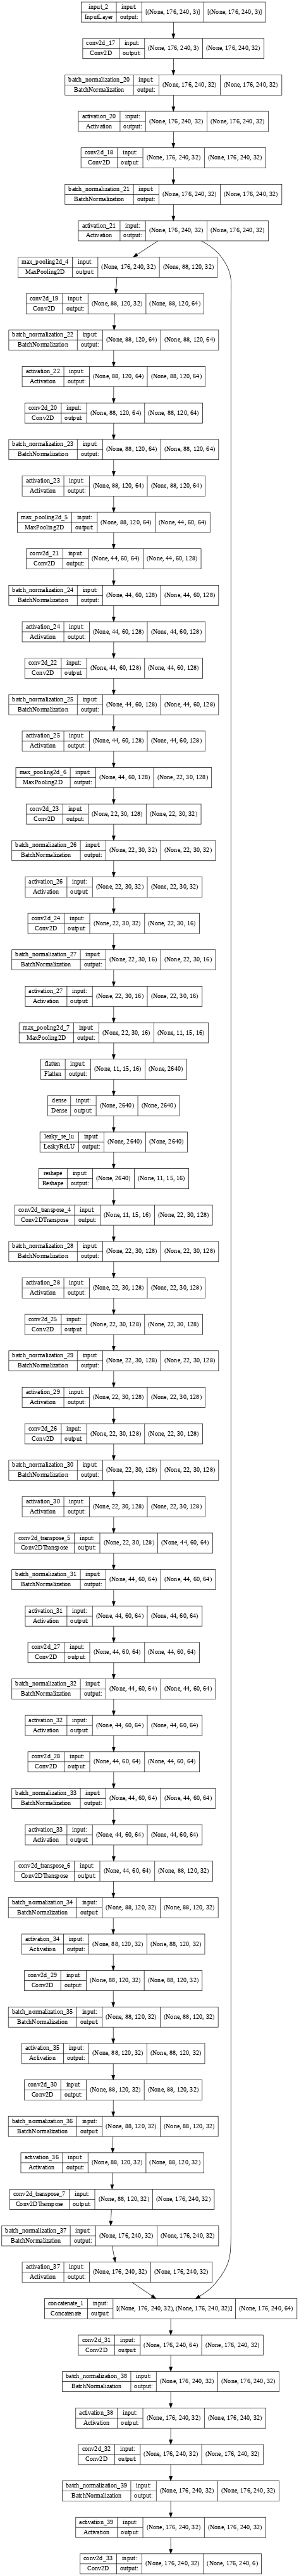

In [ ]:
plot_model(model, show_shapes=True, dpi=50)

## Обучение

In [ ]:
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data=(xVal, yVal))

Epoch 1/50
29/29 [==============================] - 10s 330ms/step - loss: 1.1031 - dice_coef: 0.3918 - val_loss: 1.5871 - val_dice_coef: 0.2146
Epoch 2/50
29/29 [==============================] - 10s 329ms/step - loss: 0.8298 - dice_coef: 0.5133 - val_loss: 1.5056 - val_dice_coef: 0.2328
Epoch 3/50
29/29 [==============================] - 10s 332ms/step - loss: 0.6573 - dice_coef: 0.6048 - val_loss: 1.4082 - val_dice_coef: 0.2651
Epoch 4/50
29/29 [==============================] - 10s 339ms/step - loss: 0.5341 - dice_coef: 0.6758 - val_loss: 1.3136 - val_dice_coef: 0.3121
Epoch 5/50
29/29 [==============================] - 10s 341ms/step - loss: 0.4642 - dice_coef: 0.7242 - val_loss: 1.2867 - val_dice_coef: 0.3541
Epoch 6/50
29/29 [==============================] - 10s 337ms/step - loss: 0.4161 - dice_coef: 0.7581 - val_loss: 1.3212 - val_dice_coef: 0.3885
Epoch 7/50
29/29 [==============================] - 10s 342ms/step - loss: 0.3737 - dice_coef: 0.7870 - val_loss: 1.1991 - val_dic

### Вывод по пункту **2**

На последней эпохе точность **73,5%**, что вышем чем в Варианте 1. 

Поэтому в пунктах **3** и **4** будет использована данная архитектура.

## Визуализация 

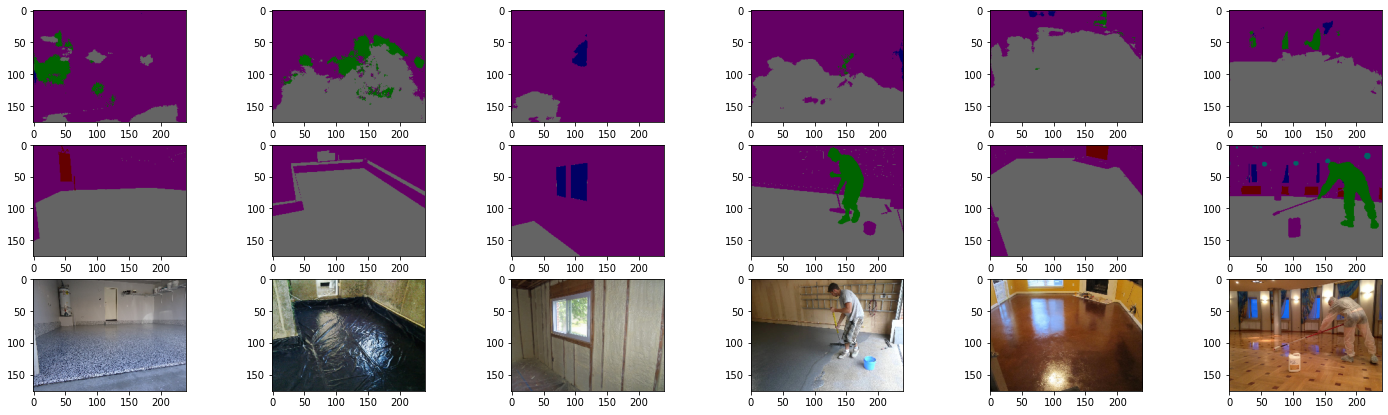

In [ ]:
processImage(model)

# 3. Проверьте различные batch_size.

- Обучение нейронной сети будет происходить в цикле. 

- verbose=**0**, чтобы не было большого вывода.

- Результат будет сохранен в таблицу **Pandas**. 

- batch_size будет равен 8, 16, 50.

## Создание таблицы Pandas

In [ ]:
df = pd.DataFrame(columns = ['batch_size', 'val_dice_coef'])    # Создаем таблицу Pandas

# Счетчик для таблицы в pd (номер строки)
count = 1 

## Обучение

In [ ]:
# 32 уже было
batch_size = [8, 16, 50]

for i in batch_size:         # Прозодимся циклом по спику значений batch_size

  model = unet_Dense()       # Каждый раз заного создает сеть

  history = model.fit(xTrain, yTrain, epochs=50, batch_size=i, validation_data=(xVal, yVal), verbose=0)   # Обчение

  df.loc[count] = [str(i), round(history.history['val_dice_coef'][-1], 3) * 100]    # Запись в таблицу
  count += 1

## Результат

In [ ]:
df

,batch_size,val_dice_coef
1,8,74.4
2,16,75.0
3,50,69.2


## Вывод по пункту **3**

Как видно из результатов batch_size=**16** показал лучший результат. Его и будем использовать в пункте **4**.

# 4. Проверьте различные активационные функции.

Функция создания нейронной сети получилось большая, для того чтобы можно было использовать **цикл** в обучении.

Так же verbose=**0**

Будет три варианта:

1. Функция активации **LeakyReLU**

2. **different** - разные функции (**tanh**, **sigmoid**, **softplus**, **selu**, **elu**)

3. Простая - **linear**

За основу будет взята сеть с Dense слоем из пункта **2**, batch_size=**16**

In [ ]:
def unet_activation(activation, num_classes=6, input_shape=(176,240,3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(32, (3,3), padding='same')(img_input)   # (176,240,3)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)


  x = Conv2D(32, (3,3), padding='same')(x)           # (176,240,32) 
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    block_1_out = LeakyReLU()(x)
  elif activation == 'different':
    block_1_out = Activation('softplus')(x)
  elif activation == 'linear':
    block_1_out = Activation('linear')(x)

  x = MaxPooling2D()(block_1_out)                    # (88,120,32)

  # Block 2

  x = Conv2D(64, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('selu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(64, (3,3), padding='same')(x)           # (88,120,64)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = MaxPooling2D()(x)                              # (44,60,32)


  # Block 3

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(128, (3,3), padding='same')(x)          # (44,60,128)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('softplus')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = MaxPooling2D()(x)                              # (22,30,64)

  # Block 4

  x = Conv2D(32, (3,3), padding='same')(x)          # (11,15,32)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('selu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(16, (3,3), padding='same')(x)          # (11,15,16)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = MaxPooling2D()(x)                              # (11,15,16)



  # Block Dense

  x = Flatten()(x)                                  # 2640
  x = Dense(11*15*16)(x)                            # 2640
  x = LeakyReLU()(x)
  x = Reshape((11,15,16))(x)                        # (11,15,16)
 


  # UP 2

  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)  # (22,30,128)
  x = BatchNormalization()(x)
  
  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(128, (3,3), padding='same')(x)                           # (22,30,128)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('softplus')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(128, (3,3), padding='same')(x)                           # (22,30,128)                         
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  # UP 3

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x)    # (44,60,128)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('softplus')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  
  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  # UP 4

  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)    # (88,120,64)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('softplus')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  # UP 5

  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x)    # (176,240,32)  
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('tanh')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = concatenate([x, block_1_out])     # Объединение слоев (176,240,32) и (176,240,32) 

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('softplus')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  x = Conv2D(32, (3,3), padding='same')(x)
  x = BatchNormalization()(x)

  # Выбор активационной функции
  if activation == 'LeakyReLU':
    x = LeakyReLU()(x)
  elif activation == 'different':
    x = Activation('elu')(x)
  elif activation == 'linear':
    x = Activation('linear')(x)

  # Выходной

  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)  # (176,240,6)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

## Создание таблицы Pandas

In [ ]:
df_activation = pd.DataFrame(columns = ['Activation', 'val_dice_coef'])

# Счетчик для таблицы в pd (номер строки)
count = 1 

## Обучение

In [ ]:
activations = ['LeakyReLU', 'different', 'linear']

for i in activations:
  model = unet_activation(i)
  history = model.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data=(xVal, yVal), verbose=0)

  df_activation.loc[count] = [i, round(history.history['val_dice_coef'][-1], 3) * 100]
  count += 1

## Результат

In [ ]:
df_activation

,Activation,val_dice_coef
1,LeakyReLU,71.6
2,different,79.3
3,linear,75.2


# 5. Выводы:

1. Добавление слоя **Dense** немного увеличило точность сети  - **73,5%**
2. При обучении с batch_size равным **16**, результат лучше - **75.0%**
3. Исользуя в разных слоях активационные функции - **tanh**, **sigmoid**, **softplus**, **selu**, **elu** показала точность **79.3%**.
  - Что лучше чем использовать одну и туже функцию **LeakyReLU** или **linear**.	
4. Для достижения наилучшего результата требуется подбирать архитектуру и гиперпараметры для каждой конкретной задачи. 

5. Данная работа позволяет лучше понять как создается своя собственная архитектура нейронной сети, как влияют активационные функции и значение batch_size. 